In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

from differt2d.geometry import Point
from differt2d.scene import Scene

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


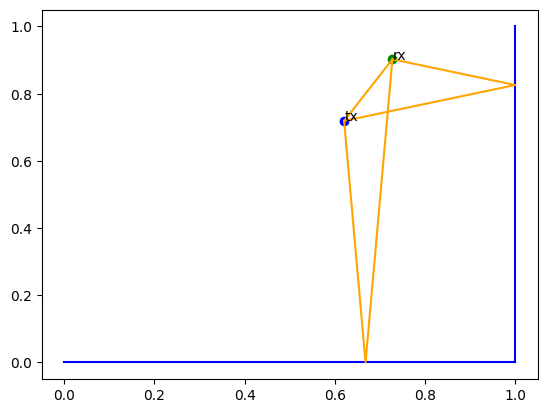

In [7]:
key = jax.random.PRNGKey(123)
key_ratio, key_points, key_mask = jax.random.split(key, 3)

ratio = jax.random.uniform(key_ratio)
points = jax.random.uniform(key_points, (2, 2))
tx = Point(point=points[0, :])
rx = Point(point=points[1, :])

scene = Scene.square_scene_with_obstacle(ratio=ratio)

key_keep, key_num = jax.random.split(key, 2)
indices = jnp.arange(len(scene.objects), dtype=jnp.uint32)
num_walls = jax.random.randint(key_num, (), minval=0, maxval=len(scene.objects))
keeps = jax.random.choice(key_keep, indices, shape=(num_walls,), replace=False)
objects = [obj for keep, obj in zip(keeps, scene.objects) if keep]

scene = scene.with_transmitters(tx=tx).with_receivers(rx=rx).with_objects(*objects)

ax = plt.gca()
scene.plot(ax)

for _, _, path, _ in scene.all_valid_paths():
    path.plot(ax)

plt.show()